### Before You Start
* 이 튜토리얼을 시작하기전에, PyTorch, TorchVision, Matplotlib, 그리고 TensorBoard를 설치해야 함.

* With Conda :

In [ ]:
conda install pytorch torchvision -c pytorch
conda install matplotlib tensorboard

* With Pip :

In [ ]:
pip install torch torchvision matplotlib tensorboard

* 해당 dependencies 들이 설치되면, 이를 설치한 Python 환경에서 이 Notebook 을 다시 시작하기.

Introduction
* 이 Notebook 에서는 Fashion-MNIST 데이터 세트에 대해 LeNet-5 변형을 훈련할 것.
* Fashion-MNIST 는 다양한 의류를 묘사하는 이미지 타일 세트로, 묘사된 의류 유형을 나타내는 10개의 클래스 라벨이 있음.

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

### Showing Images in TensorBoard
* 데이터세트의 샘플 이미지를 TensorBoard에 추가하는 것부터 시작함.

100%|██████████| 26421880/26421880 [00:03<00:00, 7670229.22it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 139395.62it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2604829.66it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6933936.09it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



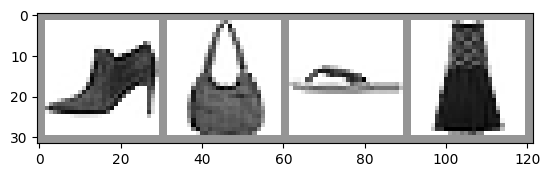

In [2]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5))]
)

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
                                                 download=True,
                                                 train=True,
                                                 transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
                                                   download=True,
                                                   train=False,
                                                   transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)

validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

* 위에서는 TorchVision 과 Matplotlib 를 사용하여 입력 데이터의 미니배치에 대한 시각적 그리드를 만듦.
* 아래에서는  SummaryWriter의 add_image() 호출을 사용하여 TensorBoard에서 사용할 이미지를 기록하고, flush()를 호출하여 해당 이미지가 디스크에 즉시 기록되는지 확인함.

In [3]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

* 명령줄에서 TensorBoard를 시작하고 새 브라우저 탭(일반적으로 localhost:6006)에서 열면 IMAGES 탭 아래에 이미지 그리드가 표시됨.

### Graphing Scalars to Visualize Training
* TensorBoard는 훈련의 진행 상황과 효율성을 추적하는데 유용함.
* 아래에서는 훈련 루프를 실행하고, 일부 측정항목을 추적하고, TensorBoard에서 사용할 데이터를 저장함.
* 이미지 타일을 분류하는 모델과 학습을 위한 최적화 프로그램 및 손실 함수를 정의해 보겠음.

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

* 이제 단일 에포크를 훈련하고 1000개 배치마다 훈련 세트와 검증 세트 손실을 평가해 보겠음.

In [5]:
print(len(validation_loader))
for epoch in range(1): # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
      # basic training loop
      inputs, labels = data
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 1000 == 999: # Every 1000 mini-batches
        print('Batch {}'.format(i + 1))
        # check against the validation set
        running_vloss = 0.0

        net.train(False) # Don't need to track gradients for validation
        for j, vdata in enumerate(validation_loader, 0):
          vinputs, vlabels = vdata
          voutputs = net(vinputs)
          vloss = criterion(voutputs, vlabels)
          running_vloss += vloss.item()
        net.train(True) # Turn gradients back on for training

        avg_loss = running_loss / 1000
        avg_vloss = running_vloss / len(validation_loader)

        # Log the running loss averaged per batch
        writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

        running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


* 열려 있는 TensorBoard로 전환하고 SCALARS 탭을 살펴보기.

### Visualizing Your Model

* TensorBoard를 사용하여 모델 내의 데이터 흐름을 검사할 수도 있음.
* 이렇게 하려면 모델 및 샘플 입력을 add_graph()를 사용하여 메서드를 호출하기.

In [6]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

* TensorBoard로 전환하면 GRAPHS 탭이 표시됨.
* 모델 내의 레이어와 데이터 흐름을 보려면 "NET" 노드를 두 번 클릭하기.

### Visualizing Your Dataset with Embeddings

* 우리가 사용하는 28 x 28 이미지 타일은 784 차원 벡터(28 * 28 = 784)로 모델링할 수 있음.
* 이를 저차원 표현에 투영하는 것이 유익함.
* 이 add_embedding() 방법은 분산이 가장 높은 3차원에 데이터 세트를 투영하고 이를 대화형 3D 차트로 표시함.
* 이 add_embedding() 방법은 분산이 가장 높은 3차원으로 투영하여 이를 자동으로 수행함.

In [7]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
  assert len(data) == len(labels)

  perm = torch.randperm(len(data))
  return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# Get the class labels for each image
class_labels = [classes[label] for label in labels]

# Log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.flush()
writer.close()

* 이제 TensorBoard로 전환하고 PROJECTOR 탭을 선택하면 투영의 3D 표현이 표시됨.
* 모델을 회전하고 확대/축소할 수 있음.
* 크고 작은 규모로 조사하고 투영된 데이터와 레이블 클러스터링에서 패턴을 발견할 수 있는지 확인해보기.
* 더 나은 가시성을 위해 다음을 수행하는 것이 좋음.
  + 왼쪽의 '색상 기준' 드롭다운에서 '라벨'을 선택함.
  + 어두운 배경에 밝은 색상의 이미지를 배치하려면 상단의 야간 모드 아이콘을 전환하기.